<center style='font-family:Computer Modern'> <h2>Prova 2<br/></h2> </center>
<center style='font-family:Computer Modern'><h4>Métodos Computacionais em Finanças <br/>IMPA 2021<br/>Bernardo Camargo Cassar<br/>Segunda-feira, 14 de Junho de 2021<br/></h4> </center>

1) Consideramos o processo,

$$ dS(t) = \mu S(t)dt + \sigma(S(t),t)S(t)dW(t). $$

Construiremos os esquemas numéricos considerando $a(S(t),t) = \mu S(t)$ e $b(S(t),t) = \sigma(S(t),t)S(t)$.

a) Nas celulas seguintes, implementaremos o esquema de Milstein:

In [1]:
## Importando pacotes
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
from utils import timing
import tqdm
#from numba import jit
sns.set(palette='magma')

In [2]:
## Implementação de Classe geral, Framework para implementação deesquemas numéricos 
## para aproximação de solução de EDE's (FEDE)
## Bernardo Camargo Cassar
## MTI license

class FEDE():

    def __init__(self, esquema, drift, difusao, M = 1000, n_discret = 10000, 
                 T = 1, S_0 = 1, seed = 32):
        
        # Definindo semente
        np.random.seed(seed)
        
        # Definindo variáveis
        self.esquema = esquema
        self.drift = drift
        self.difusao = difusao
        self.M = M
        self.n_discret = n_discret
        self.T = T
        self.S_0 = S_0
        
        # Calculando variáveis e alocando memória
        self.dt = T/n_discret     
        self.caminhos_simulados = np.zeros([M, n_discret])
        self.caminhos_simulados[:,0] = S_0
        
        # Variáveis Auxiliares
        self._ja_rodou = False
            
    def atualizar_params(self, esquema = None, drift = None, difusao = None, 
                         M = None, n_discret = None, T = None, S_0 = None, 
                         seed = None, zerar_simulações = False):
        
        # Definindo semente
        if not seed is None:
            np.random.seed(seed)
        
        # Definindo variáveis
        self.esquema = esquema if not esquema is None else self.esquema
        self.drift = drift if not drift is None else self.drift
        self.difusao = difusao if not difusao is None else self.difusao
        self.M = M if not M is None else self.M
        self.n_discret = n_discret if not n_discret is None else self.n_discret
        self.T = T if not T is None else self.T
        self.S_0 = S_0 if not S_0 is None else self.S_0
        
        # Calculando variáveis e alocando memória
        self.dt = T/n_discret
        if zerar_simulações:
            self._ja_rodou = False
            self.caminhos_simulados = np.zeros([M, n_discret])
            self.caminhos_simulados[:,0] = S_0
            
    @timing
    def run(self,*args, **kwargs):
        if not self._ja_rodou:
            self._ja_rodou = True
            return getattr(self, self.esquema)(*args, **kwargs)
        else:
            return self.caminhos_simulados
        
    #@jit(nopython=True)
    def Euler_Maruyama_Strong(self,*args, **kwargs):
        self.Z = np.random.normal(size=[self.M, self.n_discret])
        for i in range(1,self.n_discret):
            t = (i-1)*self.dt
            S = self.caminhos_simulados[:, i-1]
            self.caminhos_simulados[:,i] = S + self.drift(S)*self.dt + \
                                            self.difusao(S,t)*np.sqrt(self.dt)\
                                            *self.Z[:,i-1]
        return self.caminhos_simulados
    
    #@jit(nopython=True)
    def Euler_Maruyama_Weak(self,*args, **kwargs):
        self.Z = np.random.uniform(size=[self.M, self.n_discret])
        for i in range(1,self.n_discret):
            t = (i-1)*self.dt
            S = self.caminhos_simulados[:, i-1]
            self.caminhos_simulados[:,i] = S + self.drift(S)*self.dt + \
                                            self.difusao(S,t)*np.sqrt(self.dt)\
                                            *np.sign(self.Z[:,i-1] - .5)
        return self.caminhos_simulados
    
    #@jit(nopython=True)
    def Milstein(self,*args, **kwargs):
        primeira_derivada = kwargs['primeira_derivada']
        self.Z = np.random.normal(size=[self.M, self.n_discret])
        for i in range(1,self.n_discret):
            t = (i-1)*self.dt
            S = self.caminhos_simulados[:, i-1]
            dS = self.drift(S)*self.dt + self.difusao(S,t)*np.sqrt(self.dt)\
                                    *self.Z[:,i-1]
            self.caminhos_simulados[:, i] = S + dS + .5*primeira_derivada(S,t,dS) \
                                    *self.difusao(S,t)*(self.dt*self.Z[:,i-1]**2 \
                                    - self.dt)

        return self.caminhos_simulados
    
def plot_caminhos(caminhos_simulados,ax=None):
    
    if ax is None:
        plt.figure(figsize=(10,8))
        ax = plt.axes()
    n_discret = caminhos_simulados.shape[1]
    T = caminhos_simulados.shape[0]
    t = np.linspace(0, T, n_discret) * n_discret
    plt.plot(t, caminhos_simulados.T, linewidth=1);
    plt.show()
    
    return

Definimos a difusão como:

$$ b(S(t),t) = \sigma(S,t) S(t) = S(t) (\sigma_0 + \sigma_1 cos ( \frac{2\pi S}{K} ) sin( \frac{2\pi t}{K} ))$$

E implementamos a função para a simulação dos caminhos:

Tempo transcorrido: 16.2386 sec


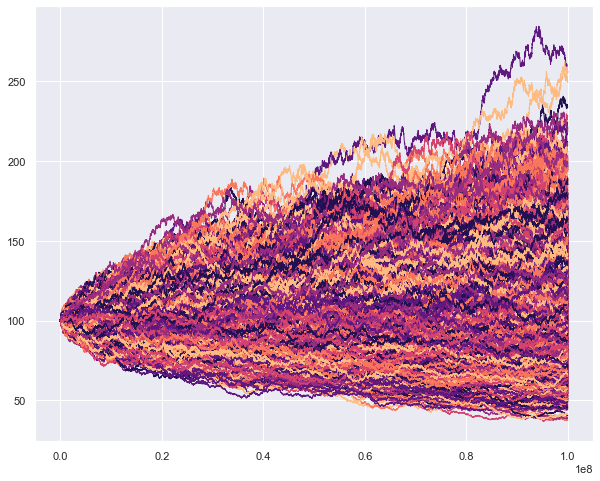

In [3]:
def item_1a(M = 10000, mu = 0.015, sigma_0 = 0.25, sigma_1 = 0.25, K = 105, S_0 = 100, T = 1, 
           esquema = 'Milstein', plot = True):
    
    drift = lambda S: S*mu
    difusao = lambda S,t: S*(sigma_0 + sigma_1*np.cos(2*np.pi*S/K)*np.sin(2*np.pi*t/K))
    primeira_derivada = lambda S,t,dS: difusao(S,t) - S*(sigma_1*np.sin(2*np.pi*S/K)*np.sin(2*np.pi*t/K)*dS)

    simulador = FEDE(esquema = esquema, drift = drift, difusao = difusao, M = M, 
                         n_discret = int(1e4), T = T, S_0 = S_0, seed = 32)
    
    caminhos_simulados = simulador.run(primeira_derivada=primeira_derivada)
    
    ## Plot
    if plot:
        plot_caminhos(caminhos_simulados)
    
    return caminhos_simulados

caminhos_simulados = item_1a()

b) Cálculo de Call Europeia utilizando o processo definido no item anterior para o ativo subjacente:

In [4]:
def item_1b(M = 10000, mu = 0.015, sigma_0 = 0.25, sigma_1 = 0.25, K = 105, S_0 = 100, T = 1, 
            r = 0.01, esquema = 'Euler_Maruyama_Weak', plot = False):
    
    drift = lambda S: S*mu
    difusao = lambda S,t: S*(sigma_0 + sigma_1*np.cos(2*np.pi*S/K)*np.sin(2*np.pi*t/K))
    primeira_derivada = lambda S,t,dS: difusao(S,t) - S*(sigma_1*np.sin(2*np.pi*S/K)*np.sin(2*np.pi*t/K)*dS)

    simulador = FEDE(esquema = esquema, drift = drift, difusao = difusao, M = M, 
                         n_discret = int(1e4), T = T, S_0 = S_0, seed = 32)
    
    caminhos_simulados = simulador.run()

    ## Calculo da opção
    C = 0
    for i in range(M):
        S = caminhos_simulados[i,-1]
        C += np.exp(-r*T)*max(S-K,0) 
    C = C/M
    print(f'Preço da Call Europeia com Strike {K}: {C}')

    ## Plot
    if plot:
        plot_caminhos(caminhos_simulados)
    
    return caminhos_simulados

caminhos_simulados = item_1b()

Tempo transcorrido: 7.9227 sec
Preço da Call Europeia com Strike 105: 9.009693587398454


c) Analogamente, calculamos o valor da Call Asiática-Europeia utilizando o processo definido no item anterior para o ativo subjacente e o método de Milstein, para obtermos uma melhor aproximação do caminho.

In [5]:
def item_1c(M = 10000, mu = 0.015, sigma_0 = 0.25, sigma_1 = 0.25, K = 105, S_0 = 100, T = 1,  
            r = 0.01, esquema = 'Milstein', plot = False):
    
    drift = lambda S: S*mu
    difusao = lambda S,t: S*(sigma_0 + sigma_1*np.cos(2*np.pi*S/K)*np.sin(2*np.pi*t/K))
    primeira_derivada = lambda S,t,dS: difusao(S,t) - S*(sigma_1*np.sin(2*np.pi*S/K)*np.sin(2*np.pi*t/K)*dS)

    simulador = FEDE(esquema = esquema, drift = drift, difusao = difusao, M = M, 
                         n_discret = int(1e4), T = T, S_0 = S_0, seed = 32)
    
    caminhos_simulados = simulador.run(primeira_derivada=primeira_derivada)

    ## Calculo da opção
    C = 0
    for i in range(M):
        y = caminhos_simulados[i,:].sum()
        C += np.exp(-r*T)*max(y/T/simulador.n_discret-K,0) 
    C = C/M
    print(f'Preço da Call Asiática-Europeia com Strike {K}: {C}')

    ## Plot
    if plot:
        plot_caminhos(caminhos_simulados)
    
    return caminhos_simulados

caminhos_simulados = item_1c()

Tempo transcorrido: 19.7142 sec
Preço da Call Asiática-Europeia com Strike 105: 4.206327652604518


2) Implementamos o método Forward Time Central Space para solução da EDP de B&S

$$ V_{j}^{i+1} = V_{j}^{i} + \frac{k\sigma(jh,ik)(jh)^2}{2h^2}(V_{j+1}^{i}-2V_{j}^{i}+V_{j-1}^{i})+\frac{rjk}{2}(V_{j+1}^{i}-V_{j-1}^{i})-rk V_{j}^{i}$$

$$ \Rightarrow V_{j}^{i+1} = (1-\frac{k\sigma(jh,ik)(jh)^2}{h^2}-rk)V_{j}^{i} + (\frac{k\sigma
(jh,ik)(jh)^2}{2h^2}+\frac{rjk}{2})V_{j+1}^{i}+(\frac{k\sigma
(jh,ik)(jh)^2}{2h^2}-\frac{rjk}{2})V_{j-1}^{i}$$

In [6]:
## Forward Time Central Space (FTCS)
## Bernardo Camargo Cassar
## MIT license
## Baseado em:
## Higham, D. J. (2004). Black-Scholes for scientific computing students. 
## Computing in Science & Engineering, 6(6), 72-79.

def FTCS(sigma_0 = 0.5**2, sigma_1 = 0.01, 
         K = 4, S_0 = 1, T = 1, r = 0.03, L = 10,
         n_discret_x = 11, n_discret_t = 1000):
    
    # Variáveis Auxiliares
    h = L/n_discret_x
    k  = T/n_discret_t
    X = lambda j: h*j
    t = lambda i: k*i
    sigma = lambda S,t: (sigma_0 + sigma_1*np.exp(-((S/K-1)**2))\
                     *np.cos(2*np.pi*t/T))   
    x_rng = np.linspace(0,L,n_discret_x)
    t_rng = np.linspace(0,T,n_discret_t)
    
    # Matriz de preços da Call
    C = np.zeros([n_discret_x, n_discret_t])
    
    # Condições de Contorno
    C[:,0] = np.maximum(x_rng-K,0)
    C[0,:] = 0
    C[-1,:] = L
        
    # Loop
    for i in tqdm.tqdm_notebook(range(n_discret_t-1)):
        for j in range(n_discret_x-1):
            # Calculando Vol
            sigma_i_j = sigma(X(j),t(i))

            C[j,i+1] = (1 -(k*sigma_i_j*(j**2))-r*k)*C[j,i] \
                        + (((k*sigma_i_j*(j**2)/2))+(r*j*k/2))*C[j+1,i] \
                        + (((k*sigma_i_j*(j**2)/2))-(r*j*k/2))*C[j-1,i]

    
    return C

In [7]:
C = FTCS()

<ipython-input-6-f3a7e0f20422>:31: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm.tqdm_notebook(range(n_discret_t-1)):


  0%|          | 0/999 [00:00<?, ?it/s]

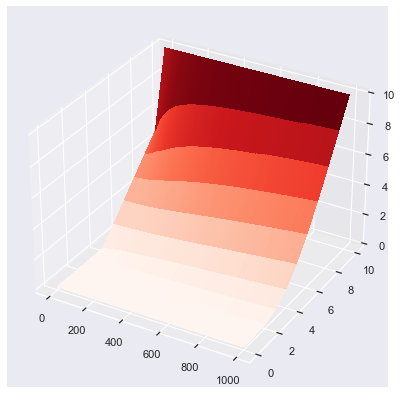

In [8]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import matplotlib.pyplot as plt
import numpy as np

fig = plt.figure(figsize=(12,7))
ax = fig.gca(projection='3d')
y, x = C.shape
Y = np.arange(0, y, 1)
X = np.arange(0, x, 1)
Y, X = np.meshgrid(Y, X)
Z = C[Y, X]
ax.plot_surface(X, Y, Z, rstride=1, cstride=1, 
        linewidth=0, antialiased=False, cmap = cm.Reds)

plt.show()